In [1]:
import preprocessing.preprocessing as pp
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, KeyedVectors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nicolas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nicolas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nicolas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nicolas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Preprocessing and visualization

In [2]:
df = pp.load_data("english_cleaned_lyrics.csv")
df = pp.preprocess_data(df)
df = df[['lyrics', 'genre']]
df

,lyrics,genre
0,oh baby know im gonna cut right chase woman ma...,Pop
1,playin everything easy like seem sure still wa...,Pop
2,search tenderness isnt hard find love need liv...,Pop
3,oh oh oh oh oh oh wrote book stand title book ...,Pop
4,party people people party popping sitting arou...,Pop
...,...,...
218205,gotta say boy couple date youre hand outright ...,Country
218206,helped find diamond ring made try everything t...,Country
218207,look couple corner booth look lot like shes lo...,Country
218208,fly mortal earth im measured depth girth fathe...,Country


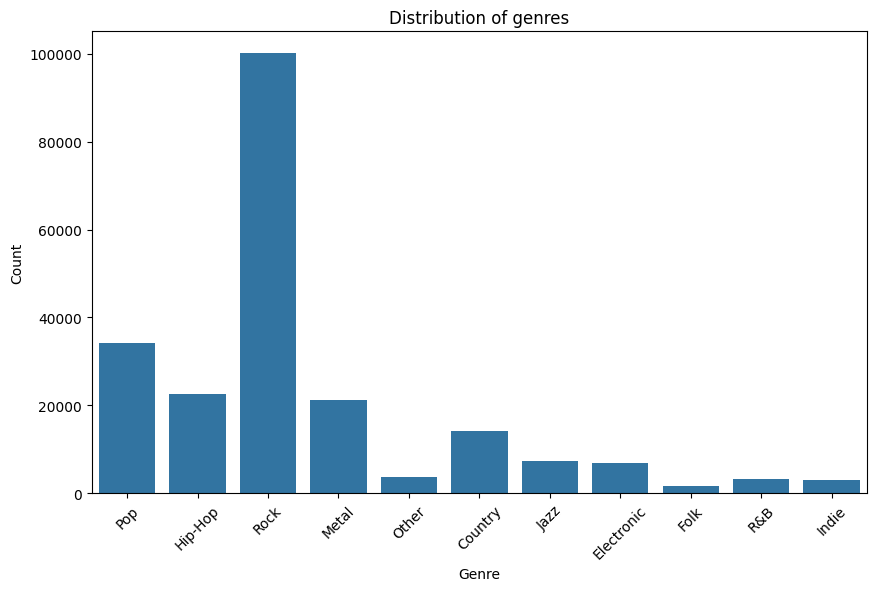

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(x='genre', data=df)

plt.title('Distribution of genres') 
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

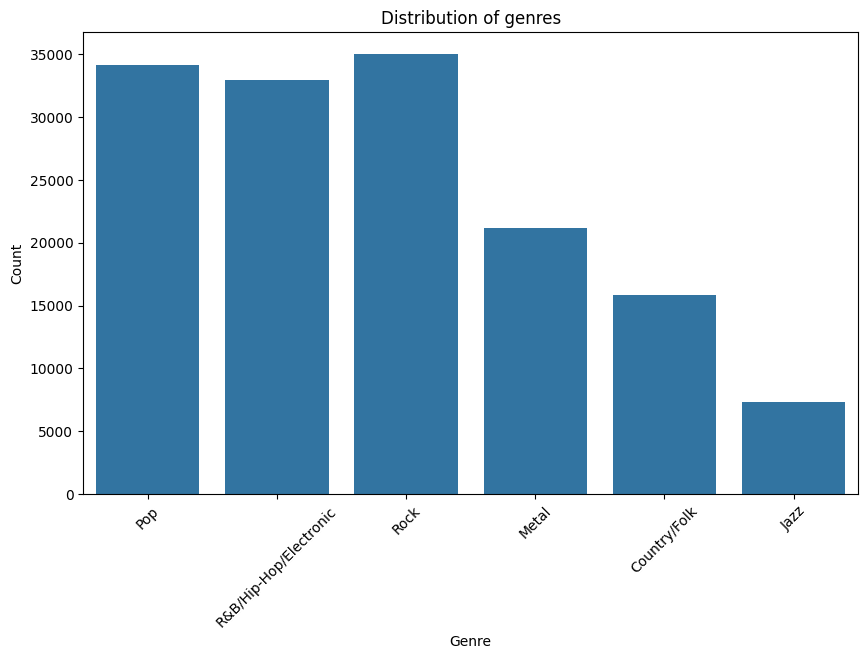

In [4]:
# Too many rocks songs, let's reduce the number of rock songs
df = pp.adjust_genre_distribution(df)

plt.figure(figsize=(10, 6))
sns.countplot(x='genre', data=df)

plt.title('Distribution of genres') 
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

# Training Word2vec

In [5]:
df['tokenized_lyrics'] = df['lyrics'].apply(word_tokenize)

In [6]:
tokenized_lyrics = df['tokenized_lyrics'].to_list()
len(tokenized_lyrics)

146436

# Creating the word2Vec model
The model seemed to work better by defining each lyrics as a sentence, instead of using sents_tokenize on each lyrics

In [7]:
model = Word2Vec(sentences=tokenized_lyrics, vector_size=50, window=5, min_count=1, workers=4)
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")
del model

In [8]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

def print_similar_words(words):
    for word in words:
        if word in wv:
            sims = wv.most_similar(word, topn=3)
            print(f"Words most similar to '{word}':")
            for sim in sims:
                print(f"{sim[0]} ({sim[1]:.4f})")
        else:
            print(f"Word '{word}' not in vocabulary.")

query_words = ['love', 'hate', 'happy', 'sad', 'baby', 'night', 'music']

print_similar_words(query_words)

Words most similar to 'love':
baby (0.7617)
loving (0.7516)
true (0.7321)
Words most similar to 'hate':
envy (0.6334)
jealousy (0.6271)
trust (0.6158)
Words most similar to 'happy':
unhappy (0.8102)
glad (0.7255)
sad (0.6584)
Words most similar to 'sad':
sadder (0.7103)
unhappy (0.6835)
happy (0.6584)
Words most similar to 'baby':
babe (0.8751)
girl (0.7973)
oh (0.7868)
Words most similar to 'night':
saturday (0.7359)
tonight (0.6822)
day (0.6755)
Words most similar to 'music':
rhythm (0.6863)
radio (0.6762)
tune (0.6704)


In [9]:
wv.most_similar('happy', topn=10)

[('unhappy', 0.8101690411567688),
 ('glad', 0.7255384922027588),
 ('sad', 0.6583650708198547),
 ('today', 0.615118682384491),
 ('kwanzaa', 0.5969609618186951),
 ('happier', 0.5955135822296143),
 ('happily', 0.5792144536972046),
 ('christmas', 0.5683313608169556),
 ('happiest', 0.5638885498046875),
 ('wonder', 0.5618907809257507)]

In [10]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

def document_vector(words):
    word_vectors = np.array([wv[word] for word in words if word in wv])

    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [11]:
document_vector("hello world")

array([-1.4985099 , -1.8969514 , -1.5216625 , -1.4986637 ,  1.1367261 ,
       -0.54994583,  0.5088463 ,  0.5130014 ,  0.76757634,  0.9167553 ,
       -2.127109  , -1.2611072 , -1.4079897 ,  1.1830022 ,  1.4875224 ,
       -1.3202021 , -0.57979137,  0.9813808 , -0.52060425, -0.27618688,
        0.48613572, -2.7214837 ,  1.630262  ,  1.4084231 ,  1.2444661 ,
       -0.8144671 , -0.70627636,  0.6292942 , -0.4791646 ,  0.57740265,
        1.6117588 , -0.51129   ,  0.47836623, -1.2917776 , -1.3184209 ,
       -3.068233  , -1.1372944 , -0.33895642, -1.530473  , -1.941946  ,
        0.265982  ,  1.1166676 ,  1.7178684 ,  0.9927958 , -0.05071112,
       -1.5880535 ,  0.8558423 ,  2.1560824 , -1.8301204 ,  0.48296374],
      dtype=float32)

# Training and test sets for Word2vec

In [12]:
X = df['tokenized_lyrics'].to_list()
y = df['genre'].to_list()

X = np.array([document_vector(lyrics) for lyrics in X])


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Features dimension: {X_train.shape}")

Features dimension: (117148, 50)


## Training: Logistic Regression with Word2vec features

In [14]:
model = LogisticRegression(random_state=42, penalty = 'l2', max_iter = 100000, class_weight='balanced')

In [15]:
model.fit(X, y)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
                         precision    recall  f1-score   support

          Country/Folk       0.36      0.50      0.41      3127
                  Jazz       0.20      0.46      0.28      1474
                 Metal       0.60      0.77      0.67      4284
                   Pop       0.47      0.38      0.42      6894
R&B/Hip-Hop/Electronic       0.69      0.61      0.65      6595
                  Rock       0.45      0.30      0.36      6914

              accuracy                           0.49     29288
             macro avg       0.46      0.50      0.46     29288
          weighted avg       0.51      0.49      0.49     29288



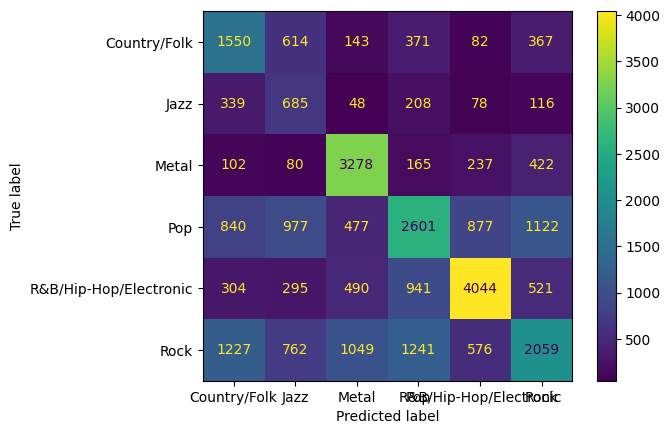

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

# Let's try our model with another genre distribution

In [ ]:
df = pp.adjust_genre_distribution(df)
df

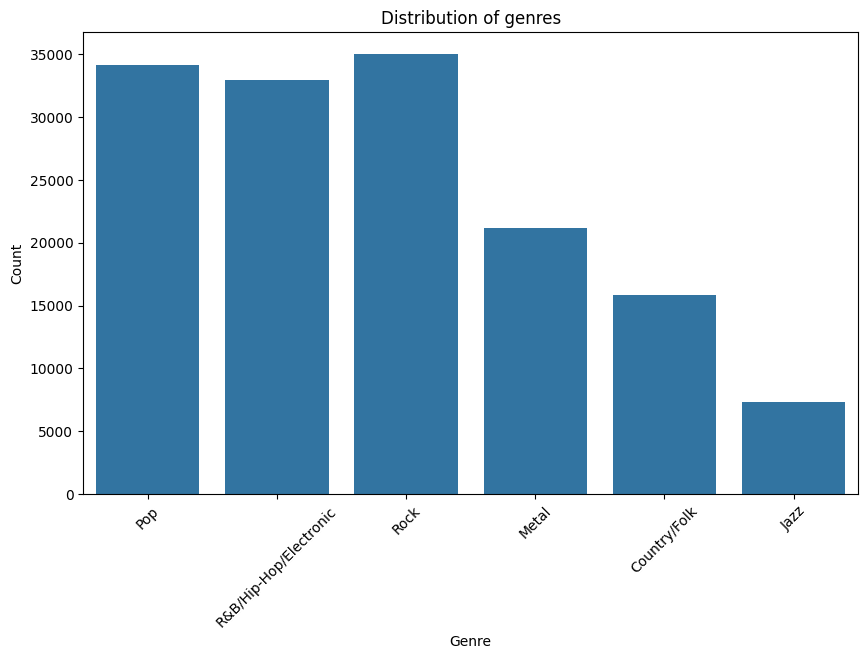

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x='genre', data=df)

plt.title('Distribution of genres') 
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

In [18]:
X = df['tokenized_lyrics'].to_list()
y = df['genre'].to_list()

X = np.array([document_vector(lyrics) for lyrics in X])


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Features dimension: {X_train.shape}")

Features dimension: (117148, 50)


In [20]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
                         precision    recall  f1-score   support

          Country/Folk       0.35      0.49      0.41      3127
                  Jazz       0.20      0.46      0.27      1474
                 Metal       0.60      0.77      0.67      4284
                   Pop       0.47      0.37      0.42      6894
R&B/Hip-Hop/Electronic       0.68      0.61      0.65      6595
                  Rock       0.44      0.30      0.35      6914

              accuracy                           0.48     29288
             macro avg       0.46      0.50      0.46     29288
          weighted avg       0.50      0.48      0.48     29288



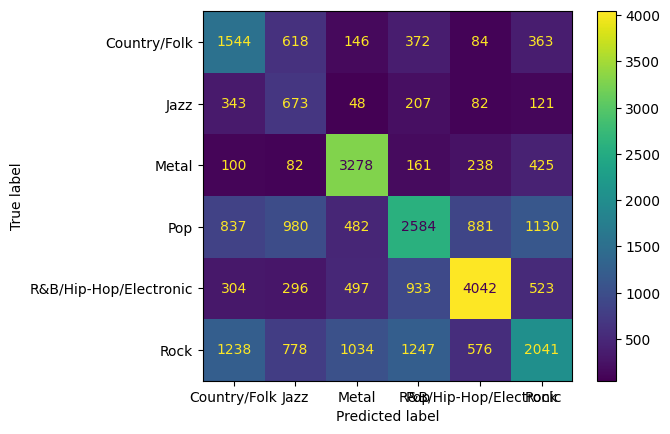

In [21]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

# Grid Search

In [22]:
model = LogisticRegression(random_state=42, max_iter=100000, class_weight='balanced')

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


In [23]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

In [24]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/home/nicolas/Prog/python-projects/NLP/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/nicolas/Prog/python-projects/NLP/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/nicolas/Prog/python-projects/NLP/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/nicolas/Prog/python-projects/NLP/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/nicolas/Prog/python-projects/NLP/venv/lib/python3.11/s

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=100000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy', verbose=1)

In [25]:
# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best model: {best_model}")


Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best model: LogisticRegression(C=1, class_weight='balanced', max_iter=100000, penalty='l1',
                   random_state=42, solver='liblinear')


In [26]:
# Evaluate the model on the test set
accuracy = best_model.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.4f}")


Test set accuracy: 0.4952


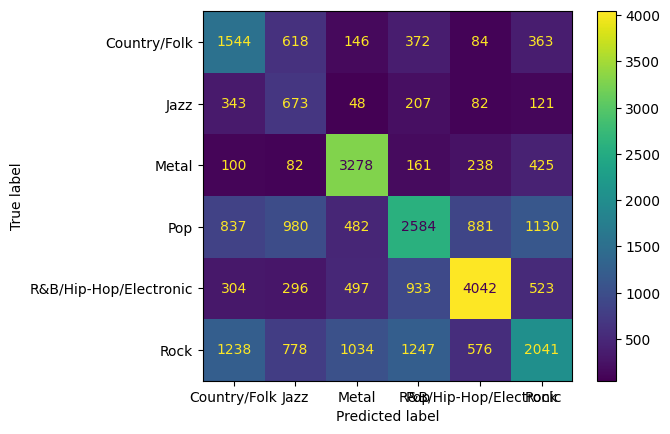

In [27]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=best_model.classes_)
disp.plot()
plt.show()

In [28]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
                         precision    recall  f1-score   support

          Country/Folk       0.35      0.49      0.41      3127
                  Jazz       0.20      0.46      0.27      1474
                 Metal       0.60      0.77      0.67      4284
                   Pop       0.47      0.37      0.42      6894
R&B/Hip-Hop/Electronic       0.68      0.61      0.65      6595
                  Rock       0.44      0.30      0.35      6914

              accuracy                           0.48     29288
             macro avg       0.46      0.50      0.46     29288
          weighted avg       0.50      0.48      0.48     29288

